 # ADDA for ST

 Creating something like CellDART but it actually follows Adda in PyTorch as a first step

In [1]:
import math
from math import ceil
import glob
import os
import datetime

from tqdm.autonotebook import tqdm

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import scanpy as sc
import anndata as ad

from sklearn.model_selection import train_test_split
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import mean_squared_error

import torch
from torch.nn import functional as F
from torch import nn

from src.model.adda import ADDAST
from src.model.datasets import SpotDataset
from src.utils.data_processing import random_mix

# datetime object containing current date and time
script_start_time = datetime.datetime.now().strftime("%Y-%m-%d_%Hh%Mm%S")


/tmp/ipykernel_411757/3165076490.py:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [3]:
results_folder = os.path.join("results", script_start_time)
model_folder = os.path.join("model", script_start_time)

model_folder = os.path.join("model", "TESTING")

if not os.path.isdir(model_folder):
    os.makedirs(model_folder)
    print(model_folder)

if not os.path.isdir(results_folder):
    os.makedirs(results_folder)


In [4]:
NUM_MARKERS = 20
N_MIX = 8
N_SPOTS = 20000

SAMPLE_ID_N = "151673"

BATCH_SIZE = 1024
NUM_WORKERS = 8
INITIAL_TRAIN_EPOCHS = 100


MIN_EPOCHS = 0.4 * INITIAL_TRAIN_EPOCHS
EARLY_STOP_CRIT = INITIAL_TRAIN_EPOCHS



 # Prepare Data
 ## Data load
 ### Load SpatialLIBD Data

In [5]:
SPATIALLIBD_DIR = "./data/spatialLIBD"

sc.logging.print_versions()
sc.set_figure_params(facecolor="white", figsize=(8, 8))
sc.settings.verbosity = 3

adata_dir = os.path.join(SPATIALLIBD_DIR, "adata")

adata_spatialLIBD_d = {}

for name in glob.glob(os.path.join(adata_dir, "adata_spatialLIBD-*.h5ad")):
    sample_id = name.partition("-")[2].rpartition(".")[0]
    # print(sample_id)
    adata_spatialLIBD_d[sample_id] = sc.read_h5ad(name)


-----
anndata     0.8.0
scanpy      1.9.1
-----
PIL                         9.2.0
asttokens                   NA
backcall                    0.2.0
beta_ufunc                  NA
binom_ufunc                 NA
bottleneck                  1.3.5
cffi                        1.15.1
colorama                    0.4.5
cycler                      0.10.0
cython_runtime              NA
dateutil                    2.8.2
debugpy                     1.5.1
decorator                   5.1.1
defusedxml                  0.7.1
entrypoints                 0.4
executing                   0.8.3
h5py                        3.6.0
igraph                      0.9.10
ipykernel                   6.15.2
ipython_genutils            0.2.0
ipywidgets                  7.6.5
jedi                        0.18.1
joblib                      1.1.0
jupyter_server              1.18.1
kiwisolver                  1.4.2
leidenalg                   0.8.10
llvmlite                    0.38.0
matplotlib                  3.5.1
matplo

 ### Load Single Cell Data

In [6]:
adata_sc_dlpfc = sc.read_h5ad("./data/sc_dlpfc/adata_sc_dlpfc.h5ad")
sc.pp.normalize_total(adata_sc_dlpfc, inplace=True, target_sum=1e6)
adata_sc_dlpfc.var_names_make_unique()


normalizing counts per cell
    finished (0:00:00)


 ## Find Marker Genes

In [7]:
# Preprocessing
# adata_sc_dlpfc.var['mt'] = adata_sc_dlpfc.var_names.str.startswith('Mt-')  # annotate the group of mitochondrial genes as 'mt'
# sc.pp.calculate_qc_metrics(adata_sc_dlpfc, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

# sc.pp.normalize_total(adata_sc_dlpfc)

# #PCA and clustering : Known markers with 'cell_subclass'
# sc.tl.pca(adata_sc_dlpfc, svd_solver='arpack')
# sc.pp.neighbors(adata_sc_dlpfc, n_neighbors=10, n_pcs=40)
# sc.tl.umap(adata_sc_dlpfc)
# sc.tl.leiden(adata_sc_dlpfc, resolution = 0.5)
# sc.pl.umap(adata_sc_dlpfc, color=['leiden','cell_subclass'])


In [8]:
# sc.tl.rank_genes_groups(adata_sc_dlpfc, 'cell_subclass', method='wilcoxon')
# # sc.pl.rank_genes_groups(adata_sc_dlpfc, n_genes=20, sharey=False)
# genelists = adata_sc_dlpfc.uns['rank_genes_groups']['names']
# df_genelists = pd.DataFrame.from_records(genelists)
# df_genelists.to_pickle('data/sc_dlpfc/df_genelists.pkl')


In [9]:
df_genelists = pd.read_pickle("data/sc_dlpfc/df_genelists.pkl")
res_genes = []
for column in df_genelists.head(NUM_MARKERS):
    res_genes.extend(df_genelists.head(NUM_MARKERS)[column].tolist())
res_genes_ = list(set(res_genes))

# with open('data/res_genes_.json', 'w') as f:
#     json.dump(res_genes_, f)


 ### Select same gene features

In [10]:
adata_spatialLIBD = ad.concat(
    adata_spatialLIBD_d.values(), label="sample_id", keys=adata_spatialLIBD_d.keys()
)
adata_spatialLIBD.obs_names_make_unique()
sc.pp.normalize_total(adata_spatialLIBD, inplace=True, target_sum=1e6)


normalizing counts per cell


/projects/wma/.conda2/envs/agreda2/lib/python3.10/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


    finished (0:00:00)


In [11]:
adata_spatialLIBD.var_names_make_unique()
inter_genes = [val for val in res_genes_ if val in adata_spatialLIBD.var.index]
print("Selected Feature Gene number", len(inter_genes))
adata_sc_dlpfc = adata_sc_dlpfc[:, inter_genes]

adata_spatialLIBD = adata_spatialLIBD[:, inter_genes]


Selected Feature Gene number 362


 ## Format Data

In [12]:
mat_sc = adata_sc_dlpfc.X.todense()
mat_sp_train = adata_spatialLIBD[
    adata_spatialLIBD.obs.sample_id == SAMPLE_ID_N
].X.todense()
# mat_sp_train = adata_spatialLIBD.X.todense()
mat_sp_test = adata_spatialLIBD[
    adata_spatialLIBD.obs.sample_id == SAMPLE_ID_N
].X.todense()

df_sc = adata_sc_dlpfc.obs

lab_sc_sub = df_sc.cell_subclass
sc_sub_dict = dict(zip(range(len(set(lab_sc_sub))), df_genelists.columns.tolist()))
sc_sub_dict2 = dict((y, x) for x, y in sc_sub_dict.items())
lab_sc_num = [sc_sub_dict2[ii] for ii in lab_sc_sub]
lab_sc_num = np.asarray(lab_sc_num, dtype="int")


 ## Generate Pseudospots

In [13]:
mat_sc_train, mat_sc_eval, lab_sc_num_train, lab_sc_num_eval = train_test_split(
    mat_sc, lab_sc_num, test_size=0.2, random_state=225, stratify=lab_sc_num
)

mat_sc_val, mat_sc_test, lab_sc_num_val, lab_sc_num_test = train_test_split(
    mat_sc_eval,
    lab_sc_num_eval,
    test_size=0.5,
    random_state=263,
    stratify=lab_sc_num_eval,
)

sc_mix_train, lab_mix_train = random_mix(
    mat_sc_train, lab_sc_num_train, nmix=N_MIX, n_samples=N_SPOTS
)
sc_mix_val, lab_mix_val = random_mix(
    mat_sc_val, lab_sc_num_val, nmix=N_MIX, n_samples=N_SPOTS // 8
)
sc_mix_test, lab_mix_test = random_mix(
    mat_sc_test, lab_sc_num_test, nmix=N_MIX, n_samples=N_SPOTS // 8
)


def log_minmaxscale(arr):
    arrd = len(arr)
    arr = np.log1p(arr)

    min2max = np.reshape((np.max(arr, axis=1) - np.min(arr, axis=1)), (arrd, 1))
    arr_minus_min = arr - np.reshape(np.min(arr, axis=1), (arrd, 1))
    return arr_minus_min / min2max


sc_mix_train_s = log_minmaxscale(sc_mix_train)
sc_mix_val_s = log_minmaxscale(sc_mix_val)
sc_mix_test_s = log_minmaxscale(sc_mix_test)

mat_sp_train_s = log_minmaxscale(mat_sp_train)
# mat_sp_val_s = log_minmaxscale(mat_sp_val)
mat_sp_test_s = log_minmaxscale(mat_sp_test)
mat_sc_s = log_minmaxscale(mat_sc)


In [14]:
source_train_set = SpotDataset(sc_mix_train_s, lab_mix_train)
source_val_set = SpotDataset(sc_mix_val_s, lab_mix_val)
source_test_set = SpotDataset(sc_mix_test_s, lab_mix_test)

target_train_set = SpotDataset(mat_sp_train_s)
target_test_set = SpotDataset(mat_sp_test_s)

dataloader_source_train = torch.utils.data.DataLoader(
    source_train_set,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=True,
)
dataloader_source_val = torch.utils.data.DataLoader(
    source_val_set,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True,
)
dataloader_source_test = torch.utils.data.DataLoader(
    source_test_set,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True,
)

dataloader_target_train = torch.utils.data.DataLoader(
    target_train_set,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=True,
)
dataloader_target_test = torch.utils.data.DataLoader(
    target_test_set,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True,
)


In [15]:
mat_sc


matrix([[    0.     ,   224.31584,     0.     , ...,     0.     ,
             0.     ,  1345.895  ],
        [  910.3323 ,   455.16614,     0.     , ...,     0.     ,
             0.     , 11834.319  ],
        [    0.     ,  1998.6676 ,     0.     , ...,     0.     ,
             0.     ,  1332.4451 ],
        ...,
        [    0.     ,     0.     ,     0.     , ...,     0.     ,
             0.     ,     0.     ],
        [    0.     ,     0.     ,     0.     , ...,     0.     ,
             0.     ,  5836.5757 ],
        [    0.     ,     0.     ,     0.     , ...,     0.     ,
             0.     ,  2610.966  ]], dtype=float32)

 # Training: Adversarial domain adaptation for cell fraction estimation

 ## Define Model

In [16]:
model = ADDAST(sc_mix_train_s.shape[1], emb_dim=64, ncls_source=lab_mix_train.shape[1])

model.to(device)


ADDAST(
  (source_encoder): MLPEncoder(
    (encoder): Sequential(
      (0): Linear(in_features=362, out_features=1024, bias=True)
      (1): BatchNorm1d(1024, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
      (2): ELU(alpha=1.0)
      (3): Linear(in_features=1024, out_features=64, bias=True)
      (4): BatchNorm1d(64, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
      (5): ELU(alpha=1.0)
    )
  )
  (target_encoder): MLPEncoder(
    (encoder): Sequential(
      (0): Linear(in_features=362, out_features=1024, bias=True)
      (1): BatchNorm1d(1024, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
      (2): ELU(alpha=1.0)
      (3): Linear(in_features=1024, out_features=64, bias=True)
      (4): BatchNorm1d(64, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
      (5): ELU(alpha=1.0)
    )
  )
  (clf): Predictor(
    (head): Sequential(
      (0): Linear(in_features=64, out_features=33, bias=True)
      (1): Log

 ## Pretrain

In [17]:
pretrain_folder = os.path.join(model_folder, "pretrain")

if not os.path.isdir(pretrain_folder):
    os.makedirs(pretrain_folder)


In [18]:
pre_optimizer = torch.optim.Adam(
    model.parameters(), lr=0.002, betas=(0.9, 0.999), eps=1e-07
)

pre_scheduler = torch.optim.lr_scheduler.OneCycleLR(
    pre_optimizer,
    max_lr=0.002,
    steps_per_epoch=len(dataloader_source_train),
    epochs=INITIAL_TRAIN_EPOCHS,
)

criterion = nn.KLDivLoss(reduction="batchmean")


In [19]:
# from copy import deepcopy

# from ignite.handlers import FastaiLRFinder

# checkpoint_0 = {
#     "model": deepcopy(model.state_dict()),
#     "pre_optimizer": deepcopy(pre_optimizer.state_dict())
# }


In [20]:
model.pretraining()


In [21]:
def compute_acc(dataloader, model):
    loss_running = []
    mean_weights = []
    model.eval()
    with torch.no_grad():
        for _, (x, y_true) in enumerate(dataloader):

            x = x.to(torch.float32).to(device)
            y_true = y_true.to(torch.float32).to(device)

            y_pred = model(x)

            loss = criterion(y_pred, y_true)

            loss_running.append(loss.item())

            # we will weight average by batch size later
            mean_weights.append(len(x))

    # print(len(loss_running), len(mean_weights))
    return np.average(loss_running, weights=mean_weights)


In [22]:
# Initialize lists to store loss and accuracy values
loss_history = []
loss_history_val = []

loss_history_running = []

# Early Stopping
best_loss_val = np.inf
early_stop_count = 0

# Train
print("Start pretrain...")
outer = tqdm(total=INITIAL_TRAIN_EPOCHS, desc="Epochs", position=0)
inner = tqdm(total=len(dataloader_source_train), desc=f"Batch", position=1)
for epoch in range(INITIAL_TRAIN_EPOCHS):

    # check to see if validation loss has plateau'd
    if early_stop_count >= EARLY_STOP_CRIT and epoch > MIN_EPOCHS:
        print(
            f"Validation loss plateaud; failed to improve after {early_stop_count} at {epoch}th epoch"
        )
        checkpoint = {
            "epoch": epoch,
            "model": model,
            "pre_optimizer": pre_optimizer,
            # 'scheduler': scheduler,
            # 'scaler': scaler
        }
        torch.save(
            checkpoint, os.path.join(pretrain_folder, f"checkpt_earlystop_{epoch}.pth")
        )
        break

    early_stop_count += 1

    # Train mode
    model.train()
    loss_running = []
    mean_weights = []

    inner.refresh()  # force print final state
    inner.reset()  # reuse bar
    for _, (x, y_true) in enumerate(dataloader_source_train):
        # lr_history_running.append(scheduler.get_last_lr())

        pre_optimizer.zero_grad()
        x = x.to(torch.float32).to(device)
        y_true = y_true.to(torch.float32).to(device)

        y_pred = model(x)

        loss = criterion(y_pred, y_true)

        loss_running.append(loss.item())

        # we will weight average by batch size later
        mean_weights.append(len(x))

        # scaler.scale(loss).backward()
        # scaler.step(optimizer)
        # scaler.update()

        loss.backward()
        pre_optimizer.step()
        # Change the learning rate
        pre_scheduler.step()

        inner.update(1)

    loss_history.append(np.average(loss_running, weights=mean_weights))

    loss_history_running.append(loss_running)

    # Evaluate mode
    model.eval()
    with torch.no_grad():
        curr_loss_val = compute_acc(dataloader_source_val, model)
        loss_history_val.append(curr_loss_val)

    # Save the best weights
    if curr_loss_val < best_loss_val:
        best_loss_val = curr_loss_val
        checkpoint = {
            "epoch": epoch,
            "model": model,
            "optimizer": pre_optimizer,
            # 'scheduler': scheduler,
            # 'scaler': scaler
        }
        torch.save(checkpoint, os.path.join(pretrain_folder, f"best_model.pth"))
        early_stop_count = 0

    # Save checkpoint every 10
    if epoch % 10 == 0 or epoch >= INITIAL_TRAIN_EPOCHS - 1:
        checkpoint = {
            "epoch": epoch,
            "model": model,
            "pre_optimizer": pre_optimizer,
            # 'scheduler': scheduler,
            # 'scaler': scaler
        }
        torch.save(checkpoint, os.path.join(pretrain_folder, f"checkpt{epoch}.pth"))

    # Print the results
    outer.update(1)
    print(
        "epoch:",
        epoch,
        "train loss:",
        round(loss_history[-1], 6),
        "validation loss:",
        round(loss_history_val[-1], 6),  # "next_lr:", scheduler.get_last_lr(),
    )

# Save final model
checkpoint = {
    "epoch": epoch,
    "model": model,
    "pre_optimizer": pre_optimizer,
    # 'scheduler': scheduler,
    # 'scaler': scaler
}
torch.save(checkpoint, os.path.join(pretrain_folder, f"final_model.pth"))


Start pretrain...


Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Batch:   0%|          | 0/20 [00:00<?, ?it/s]

epoch: 0 train loss: 1.742537 validation loss: 1.574149
epoch: 1 train loss: 1.482429 validation loss: 1.392924
epoch: 2 train loss: 1.363332 validation loss: 1.30529
epoch: 3 train loss: 1.282601 validation loss: 1.234401
epoch: 4 train loss: 1.216056 validation loss: 1.181641
epoch: 5 train loss: 1.152716 validation loss: 1.133431
epoch: 6 train loss: 1.088185 validation loss: 1.102103
epoch: 7 train loss: 1.021024 validation loss: 1.011607
epoch: 8 train loss: 0.95142 validation loss: 0.901669
epoch: 9 train loss: 0.880123 validation loss: 0.887779
epoch: 10 train loss: 0.808711 validation loss: 0.80598
epoch: 11 train loss: 0.740279 validation loss: 0.853824
epoch: 12 train loss: 0.677727 validation loss: 0.717512
epoch: 13 train loss: 0.625413 validation loss: 0.703415
epoch: 14 train loss: 0.588766 validation loss: 0.692774
epoch: 15 train loss: 0.56033 validation loss: 1.035331
epoch: 16 train loss: 0.540314 validation loss: 0.711004
epoch: 17 train loss: 0.520987 validation los

 ## Adversarial Adaptation

In [23]:
EPOCHS = 50
MIN_EPOCHS_ADV = 0.4 * EPOCHS
EARLY_STOP_CRIT_ADV = EPOCHS

In [24]:
best_checkpoint = torch.load(os.path.join(pretrain_folder, f"best_model.pth"))
model = best_checkpoint["model"]
model.to(device)

model.advtraining()


In [25]:
def cycle_iter(iter):
    while True:
        yield from iter


In [26]:
advtrain_folder = os.path.join(model_folder, "advtrain")

if not os.path.isdir(advtrain_folder):
    os.makedirs(advtrain_folder)

criterion = nn.CrossEntropyLoss()

target_optimizer = torch.optim.Adam(
    model.target_encoder.parameters(), lr=0.0005, betas=(0.9, 0.999), eps=1e-07
)

dis_optimizer = torch.optim.Adam(
    model.dis.parameters(), lr=0.00025, betas=(0.9, 0.999), eps=1e-07
)

iters = max(len(dataloader_source_train), len(dataloader_target_train))

dis_scheduler = torch.optim.lr_scheduler.OneCycleLR(
    dis_optimizer, max_lr=0.0005, steps_per_epoch=iters, epochs=EPOCHS
)
target_scheduler = torch.optim.lr_scheduler.OneCycleLR(
    target_optimizer, max_lr=0.0005, steps_per_epoch=iters, epochs=EPOCHS
)


In [27]:
p = len(source_train_set) / (len(source_train_set) + len(target_train_set))
rand_loss = -(p * np.log(0.5)) - (1 - p) * np.log(0.5)


In [28]:
# N_ITER = 3000

# ALPHA_LR = 5

# # Initialize lists to store loss and accuracy values
# loss_history_running = []

# batch_cycler_s = cycle_iter(dataloader_source_train)
# batch_cycler_t = cycle_iter(dataloader_target_train)

# # Train
# print("Start adversarial training...")
# outer = tqdm(total=n_iter, desc='Iterations', position=0)

# #Train mode
# model.train()
# model.dis.train()
# model.target_encoder.train()

# model.advtraining()

# loss_running = []
# accu_running = []
# mean_weights = []

# for iters in range(n_iter):
#     model.train_discriminator()

#     x_source, _ = next(batch_cycler_s)
#     x_target = next(batch_cycler_t)
#     x_source, x_target = x_source.to(device), x_target.to(device)

#     dis_optimizer.zero_grad()
#     y_dis = torch.cat(
#         [
#             torch.ones(x_source.shape[0], device=device, dtype=torch.long),
#             torch.zeros(x_target.shape[0], device=device, dtype=torch.long)
#         ]
#     )

#     emb_source = model.source_encoder(x_source).view(x_source.shape[0], -1)
#     emb_target = model.target_encoder(x_target).view(x_target.shape[0], -1)

#     emb_all = torch.cat((emb_source, emb_target))

#     y_pred = model.dis(emb_all)

#     loss = criterion(y_pred, y_dis)
#     loss_running.append(loss.item())
#     accu_running.append(
#         torch.mean(
#             (torch.flatten(torch.argmax(y_pred,
#                                         dim=1)) == y_dis).to(torch.float32)
#         )
#     )
#     # we will weight average by batch size later
#     mean_weights.append(len(y_dis))

#     # scaler.scale(loss).backward()
#     # scaler.step(optimizer)
#     # scaler.update()

#     loss.backward()
#     dis_optimizer.step()

#     model.train_target_encoder()

#     x_target = next(batch_cycler_t)
#     x_target = x_target.to(device)

#     target_optimizer.zero_grad()
#     # flip label
#     y_dis = torch.ones(x_target.shape[0], device=device, dtype=torch.long)

#     emb_target = model.target_encoder(x_target).view(x_target.shape[0], -1)
#     y_pred = model.dis(emb_target)
#     loss = criterion(y_pred, y_dis)

#     loss.backward()
#     target_optimizer.step()

#     # Save checkpoint every 100
#     if iters % 100 == 99 or iters >= n_iter - 1:
#         checkpoint = {
#             'epoch': iters,
#             'model': model,
#             'dis_optimizer': dis_optimizer,
#             'target_optimizer': target_optimizer,

#             # 'scheduler': scheduler,
#             # 'scaler': scaler
#         }
#         torch.save(
#             checkpoint, os.path.join(advtrain_folder, f'checkpt{iters}.pth')
#         )


#         accu_running[-100:] = [x.cpu() for x in accu_running[-100:]]

#         # Print the results
#         print(
#             "iter:", iters, \
#             "dis loss:", round(np.average(loss_running[-100:], weights=mean_weights[-100:]), 6), \
#             "dis accu:", round(np.average(accu_running[-100:], weights=mean_weights[-100:]), 6), \
#             # "next_lr:", scheduler.get_last_lr(),

#         )

#     outer.update(1)

# # Save final model

# checkpoint = {
#     'epoch': n_iter,
#     'model': model,
#     'dis_optimizer': dis_optimizer,
#     'target_optimizer': target_optimizer,

#     # 'scheduler': scheduler,
#     # 'scaler': scaler
# }

# torch.save(checkpoint, os.path.join(advtrain_folder, f'final_model.pth'))


In [29]:
# Initialize lists to store loss and accuracy values
loss_history = []
accu_history = []
loss_history_running = []

# Early Stopping
best_loss_val = np.inf
early_stop_count = 0

batch_cycler = zip(
    cycle_iter(dataloader_source_train), cycle_iter(dataloader_target_train)
)

# Train
print("Start adversarial training...")
print("Discriminator target loss:", rand_loss)
outer = tqdm(total=EPOCHS, desc="Epochs", position=0)
inner1 = tqdm(total=iters, desc=f"Batch (Discriminator)", position=1)
inner2 = tqdm(total=iters, desc=f"Batch (Encoder)", position=2)
for epoch in range(EPOCHS):

    # check to see if validation loss has plateau'd
    if early_stop_count >= EARLY_STOP_CRIT_ADV and epoch > MIN_EPOCHS_ADV:
        print(
            f"Discriminator loss plateaud; failed to get worse after {early_stop_count} at {epoch}th epoch"
        )
        checkpoint = {
            "epoch": EPOCHS,
            "model": model,
            "dis_optimizer": dis_optimizer,
            "target_optimizer": target_optimizer,
            # 'dis_scheduler': dis_scheduler,
            # 'target_scheduler': target_scheduler,
            # # 'scaler': scaler
        }
        torch.save(
            checkpoint, os.path.join(advtrain_folder, f"checkpt_earlystop_{epoch}.pth")
        )
        break

    early_stop_count += 1

    # Train mode
    model.train()

    loss_running = []
    accu_running = []
    mean_weights = []

    model.train_discriminator()
    model.target_encoder.eval()
    model.source_encoder.eval()
    model.dis.train()

    inner1.refresh()  # force print final state
    inner1.reset()  # reuse bar
    inner2.refresh()  # force print final state
    inner2.reset()  # reuse bar
    for _ in range(iters):
        # lr_history_running.append(scheduler.get_last_lr())

        # for iters in range(n_iter):

        (x_source, _), (x_target) = next(batch_cycler)
        x_source, x_target = x_source.to(device), x_target.to(device)

        dis_optimizer.zero_grad()
        y_dis = torch.cat(
            [
                torch.ones(x_source.shape[0], device=device, dtype=torch.long),
                torch.zeros(x_target.shape[0], device=device, dtype=torch.long),
            ]
        )

        emb_source = model.source_encoder(x_source).view(x_source.shape[0], -1)
        emb_target = model.target_encoder(x_target).view(x_target.shape[0], -1)

        emb_all = torch.cat((emb_source, emb_target))

        y_pred = model.dis(emb_all)

        #     # we will weight average by batch size later
        mean_weights.append(len(y_dis))

        #     # scaler.scale(loss).backward()
        #     # scaler.step(optimizer)
        #     # scaler.update()

        loss = criterion(y_pred, y_dis)
        loss_running.append(loss.item())
        accu_running.append(
            torch.mean(
                (torch.flatten(torch.argmax(y_pred, dim=1)) == y_dis).to(torch.float32)
            )
        )

        # scaler.scale(loss).backward()
        # scaler.step(optimizer)
        # scaler.update()

        loss.backward()
        dis_optimizer.step()
        dis_scheduler.step()

        inner1.update(1)

    accu_running = [x.cpu() for x in accu_running]

    loss_history.append(np.average(loss_running, weights=mean_weights))
    accu_history.append(np.average(accu_running, weights=mean_weights))

    loss_history_running.append(loss_running)

    model.train_target_encoder()
    model.target_encoder.train()
    model.source_encoder.eval()
    model.dis.eval()
    for _ in range(iters):
        _, x_target = next(batch_cycler)
        x_target = x_target.to(device)

        target_optimizer.zero_grad()

        # flip label
        y_dis = torch.ones(x_target.shape[0], device=device, dtype=torch.long)

        emb_target = model.target_encoder(x_target).view(x_target.shape[0], -1)
        y_pred = model.dis(emb_target)
        loss = criterion(y_pred, y_dis)

        loss.backward()
        target_optimizer.step()
        target_scheduler.step()

        inner2.update(1)

    # Save the best weights
    if math.fabs(loss_history[-1] - rand_loss) < best_loss_val:
        best_loss_val = math.fabs(loss_history[-1] - rand_loss)
        checkpoint = {
            "epoch": iters,
            "model": model,
            "dis_optimizer": dis_optimizer,
            "target_optimizer": target_optimizer,
            # 'dis_scheduler': dis_scheduler,
            # 'target_scheduler': target_scheduler,
        }
        torch.save(checkpoint, os.path.join(advtrain_folder, f"best_model.pth"))

        early_stop_count = 0

    # Save checkpoint every 10
    if epoch % 10 == 0 or epoch >= EPOCHS - 1:
        checkpoint = {
            "epoch": iters,
            "model": model,
            "dis_optimizer": dis_optimizer,
            "target_optimizer": target_optimizer,
            # 'dis_scheduler': dis_scheduler,
            # 'target_scheduler': target_scheduler,
        }
        torch.save(checkpoint, os.path.join(advtrain_folder, f"checkpt{iters}.pth"))

    # Print the results
    outer.update(1)
    print(
        "epoch:",
        epoch,
        "dis loss:",
        round(loss_history[-1], 6),
        "dis accu:",
        round(accu_history[-1], 6),
        "difference from random loss:",
        round(math.fabs(loss_history[-1] - rand_loss), 6)
        # "next_lr:", scheduler.get_last_lr(),
    )

# Save final model
checkpoint = {
    "epoch": iters,
    "model": model,
    "dis_optimizer": dis_optimizer,
    "target_optimizer": target_optimizer,
    # 'dis_scheduler': dis_scheduler,
    # 'target_scheduler': target_scheduler,
}
torch.save(checkpoint, os.path.join(advtrain_folder, f"final_model.pth"))


Start adversarial training...
Discriminator target loss: 0.6931471805599453


Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Batch (Discriminator):   0%|          | 0/20 [00:00<?, ?it/s]

Batch (Encoder):   0%|          | 0/20 [00:00<?, ?it/s]

epoch: 0 dis loss: 0.665022 dis accu: 0.64498 difference from random loss: 0.028125
epoch: 1 dis loss: 0.749707 dis accu: 0.498207 difference from random loss: 0.05656
epoch: 2 dis loss: 0.772423 dis accu: 0.463202 difference from random loss: 0.079275
epoch: 3 dis loss: 0.787556 dis accu: 0.443042 difference from random loss: 0.094409
epoch: 4 dis loss: 0.779467 dis accu: 0.451054 difference from random loss: 0.08632
epoch: 5 dis loss: 0.756478 dis accu: 0.475979 difference from random loss: 0.063331
epoch: 6 dis loss: 0.732578 dis accu: 0.501872 difference from random loss: 0.039431
epoch: 7 dis loss: 0.697226 dis accu: 0.556644 difference from random loss: 0.004079
epoch: 8 dis loss: 0.662822 dis accu: 0.608457 difference from random loss: 0.030325
epoch: 9 dis loss: 0.625704 dis accu: 0.661474 difference from random loss: 0.067443
epoch: 10 dis loss: 0.612378 dis accu: 0.682917 difference from random loss: 0.080769
epoch: 11 dis loss: 0.566943 dis accu: 0.736484 difference from ran

 # 4. Predict cell fraction of spots and visualization

In [30]:
best_checkpoint = torch.load(os.path.join(advtrain_folder, f"best_model.pth"))
model = best_checkpoint["model"]
model.to(device)
model.eval()
model.target_inference()

pred_sp = (
    F.softmax(model(torch.Tensor(mat_sp_test_s).to(device)), dim=1)
    .detach()
    .cpu()
    .numpy()
)
adata_spatialLIBD_151673 = adata_spatialLIBD[
    adata_spatialLIBD.obs.sample_id == SAMPLE_ID_N
]

adata_spatialLIBD_151673.obsm["spatial"] = adata_spatialLIBD_151673.obs[
    ["X", "Y"]
].values


In [31]:
best_checkpoint = torch.load(os.path.join(pretrain_folder, f"best_model.pth"))
model = best_checkpoint["model"]
model.to(device)
model.eval()
model.set_encoder("source")

pred_sp_noda = (
    F.softmax(model(torch.Tensor(mat_sp_test_s).to(device)), dim=1)
    .detach()
    .cpu()
    .numpy()
)
# adata_spatialLIBD_151673 =  adata_spatialLIBD[adata_spatialLIBD.obs.sample_id == 151673]

# adata_spatialLIBD_151673.obsm['spatial'] = adata_spatialLIBD_151673.obs[['X','Y']].values


In [32]:
num_name_exN_l = []
for k, v in sc_sub_dict.items():
    if "Ex" in v:
        num_name_exN_l.append((k, v, int(v.split("_")[1])))
num_name_exN_l.sort(key=lambda a: a[2])
num_name_exN_l


[(4, 'Ex_1_L5_6', 1),
 (5, 'Ex_2_L5', 2),
 (6, 'Ex_3_L4_5', 3),
 (7, 'Ex_4_L_6', 4),
 (8, 'Ex_5_L5', 5),
 (9, 'Ex_6_L4_6', 6),
 (10, 'Ex_7_L4_6', 7),
 (11, 'Ex_8_L5_6', 8),
 (12, 'Ex_9_L5_6', 9),
 (13, 'Ex_10_L2_4', 10)]

In [33]:
Ex_to_L_d = {
    1: {5, 6},
    2: {5},
    3: {4, 5},
    4: {6},
    5: {5},
    6: {4, 5, 6},
    7: {4, 5, 6},
    8: {5, 6},
    9: {5, 6},
    10: {2, 3, 4},
}


In [34]:
numlist = [t[0] for t in num_name_exN_l]
Ex_l = [t[2] for t in num_name_exN_l]
num_to_ex_d = dict(zip(numlist, Ex_l))


In [35]:
def plot_cellfraction(visnum, adata, pred_sp, ax=None):
    """Plot predicted cell fraction for a given visnum"""
    adata.obs["Pred_label"] = pred_sp[:, visnum]
    # vmin = 0
    # vmax = np.amax(pred_sp)

    sc.pl.spatial(
        adata,
        img_key="hires",
        color="Pred_label",
        palette="Set1",
        size=1.5,
        legend_loc=None,
        title=f"{sc_sub_dict[visnum]}",
        spot_size=100,
        show=False,
        # vmin=vmin,
        # vmax=vmax,
        ax=ax,
    )


In [36]:
# def plot_cell_layers(df):

#     layer_idx = df["spatialLIBD"].unique().astype(str)
#     samples = df["sample_id"].unique()
#     layer_idx.sort()
#     fig, ax = plt.subplots(nrows = 1, ncols = len(samples), figsize = (5*len(samples),5), squeeze=False, constrained_layout=True)


#     for idx, sample in enumerate(samples):
#         cells_of_samples = df[df["sample_id"] == sample]
#         for index in layer_idx:
#             cells_of_layer = cells_of_samples[cells_of_samples["spatialLIBD"] == index]
#             ax.flat[idx].scatter(cells_of_layer["X"], -cells_of_layer["Y"], label = index, s=17, marker='o')

#         ax.flat[idx].axis('equal')
#         ax.flat[idx].set_xticks([])
#         ax.flat[idx].set_yticks([])
#         ax.flat[idx].set_title(sample)

#     plt.legend()
#     plt.show()


In [37]:
def plot_roc(visnum, adata, pred_sp, name, ax=None):
    """Plot ROC for a given visnum"""

    def layer_to_layer_number(x):
        for char in x:
            if char.isdigit():
                if int(char) in Ex_to_L_d[num_to_ex_d[visnum]]:
                    return 1
        return 0

    y_pred = pred_sp[:, visnum]
    y_true = adata.obs["spatialLIBD"].map(layer_to_layer_number).fillna(0)
    # print(y_true)
    # print(y_true.isna().sum())
    RocCurveDisplay.from_predictions(y_true=y_true, y_pred=y_pred, name=name, ax=ax)


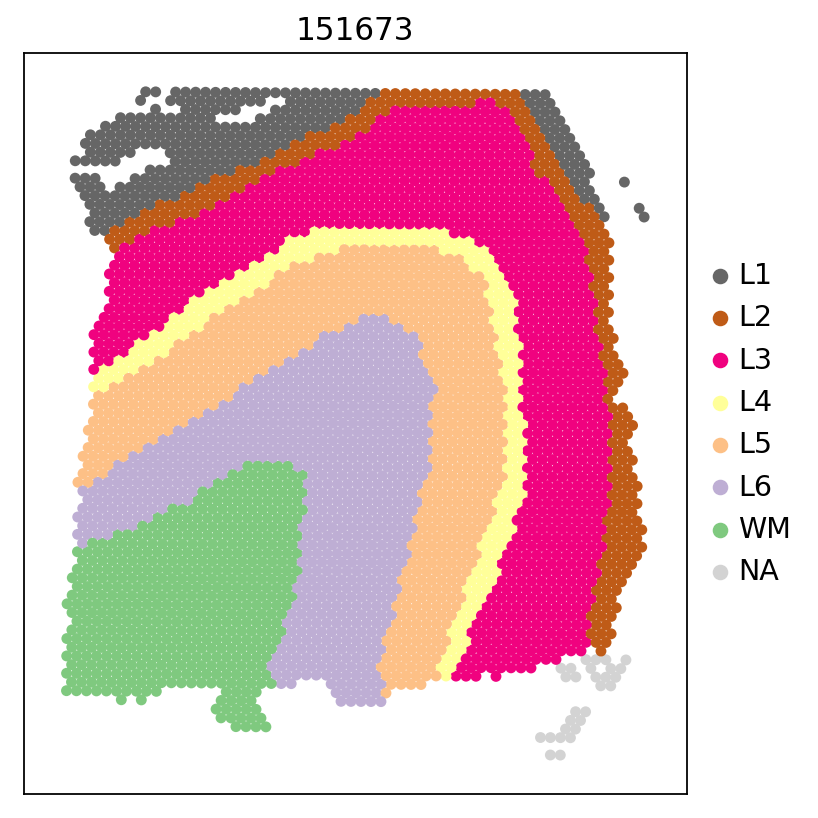

In [38]:
# plot_cell_layers(adata_spatialLIBD_151673.obs)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5), constrained_layout=True)

sc.pl.spatial(
    adata_spatialLIBD_151673,
    img_key=None,
    color="spatialLIBD",
    palette="Accent_r",
    size=1.5,
    title=f"{SAMPLE_ID_N}",
    # legend_loc = 4,
    spot_size=100,
    show=False,
    ax=ax,
)

ax.axis("equal")
ax.set_xlabel("")
ax.set_ylabel("")

fig.show()


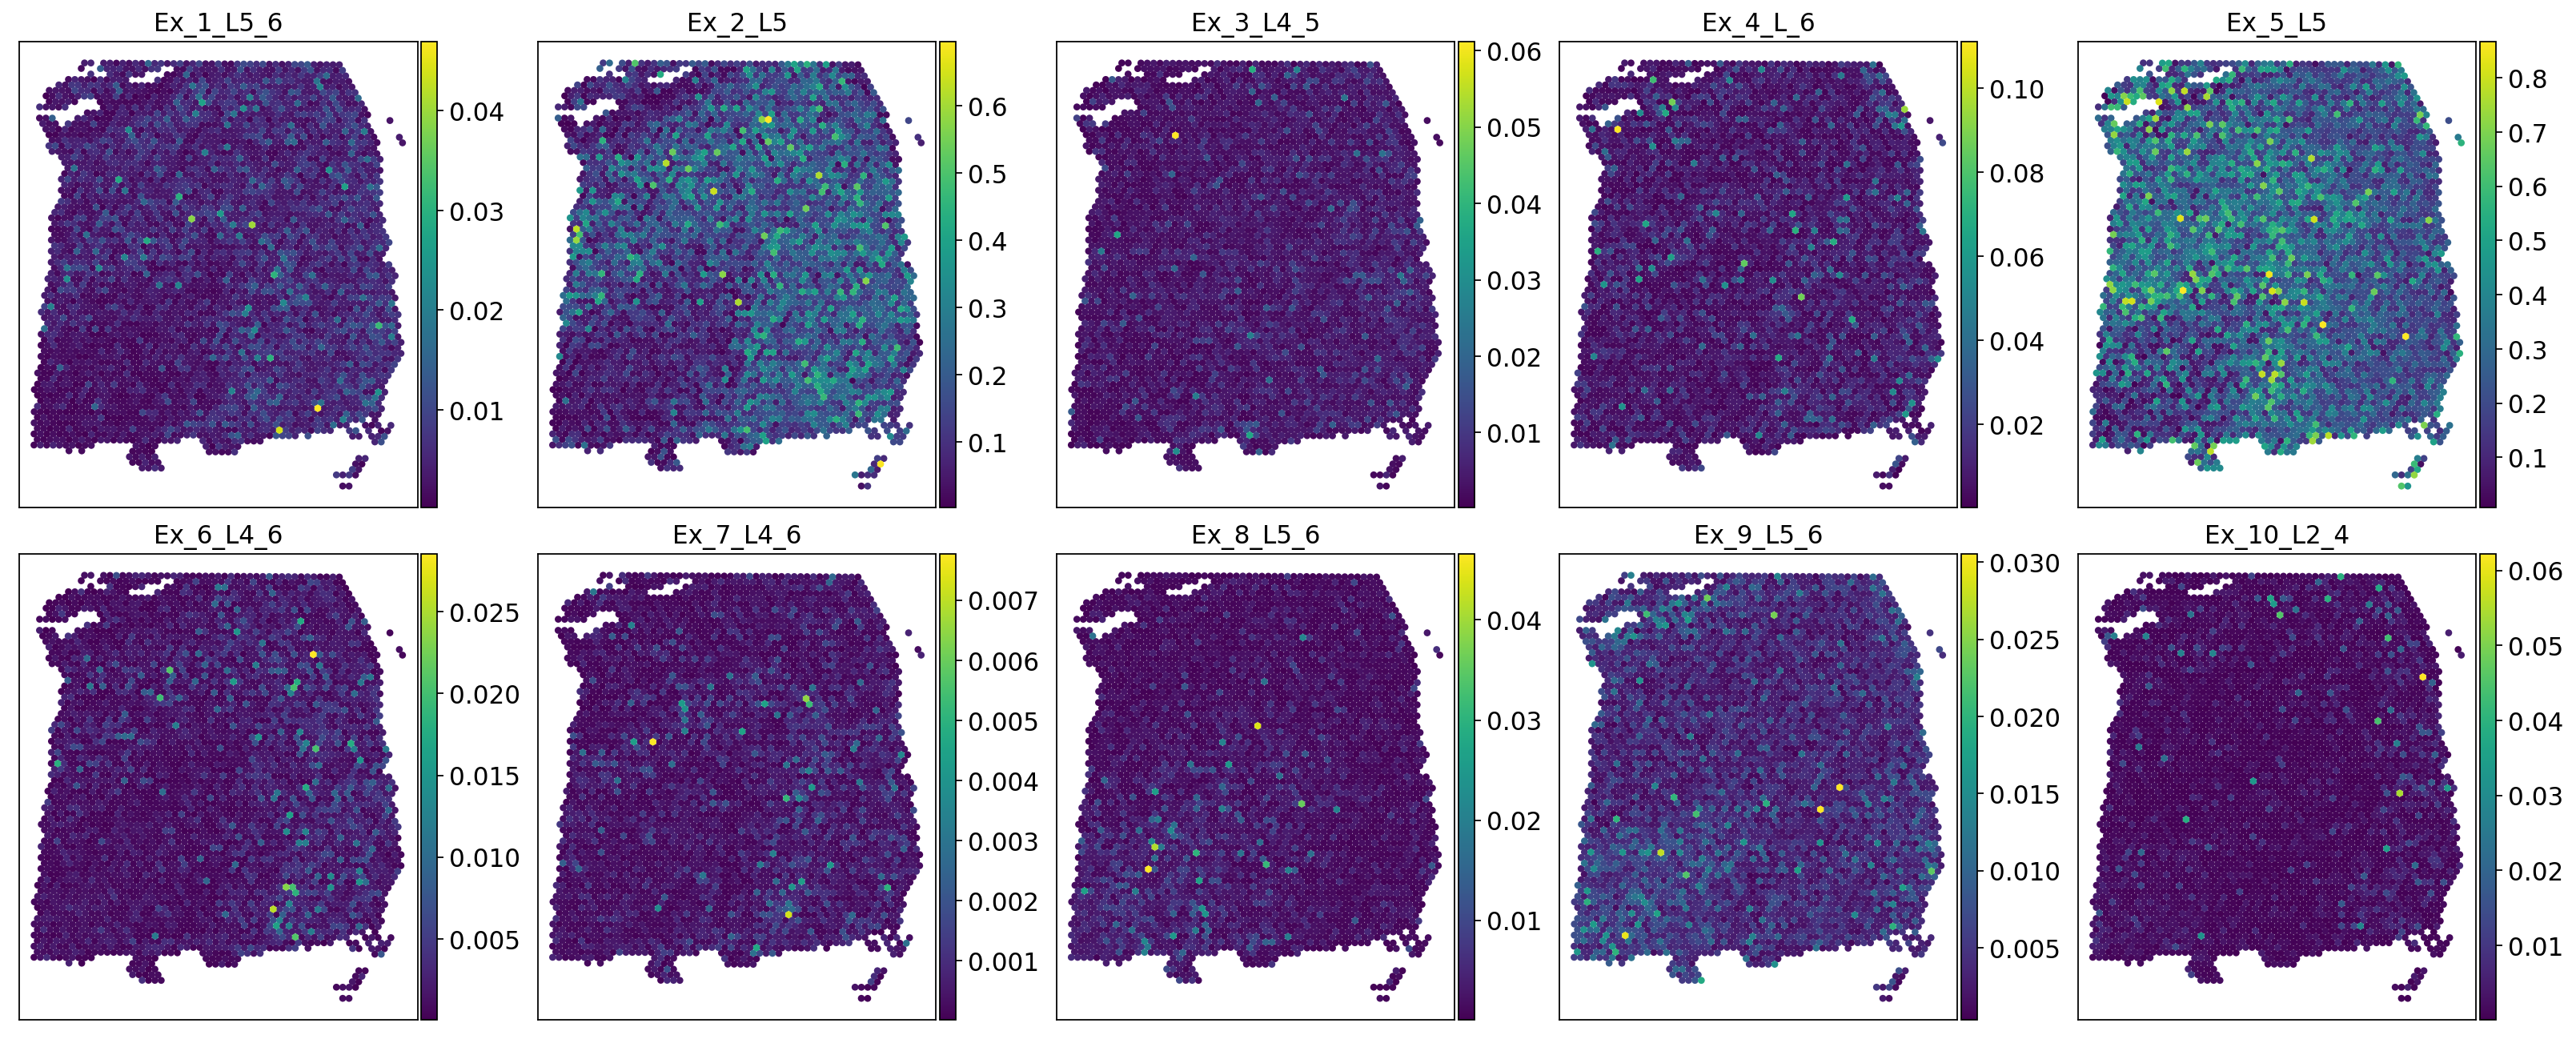

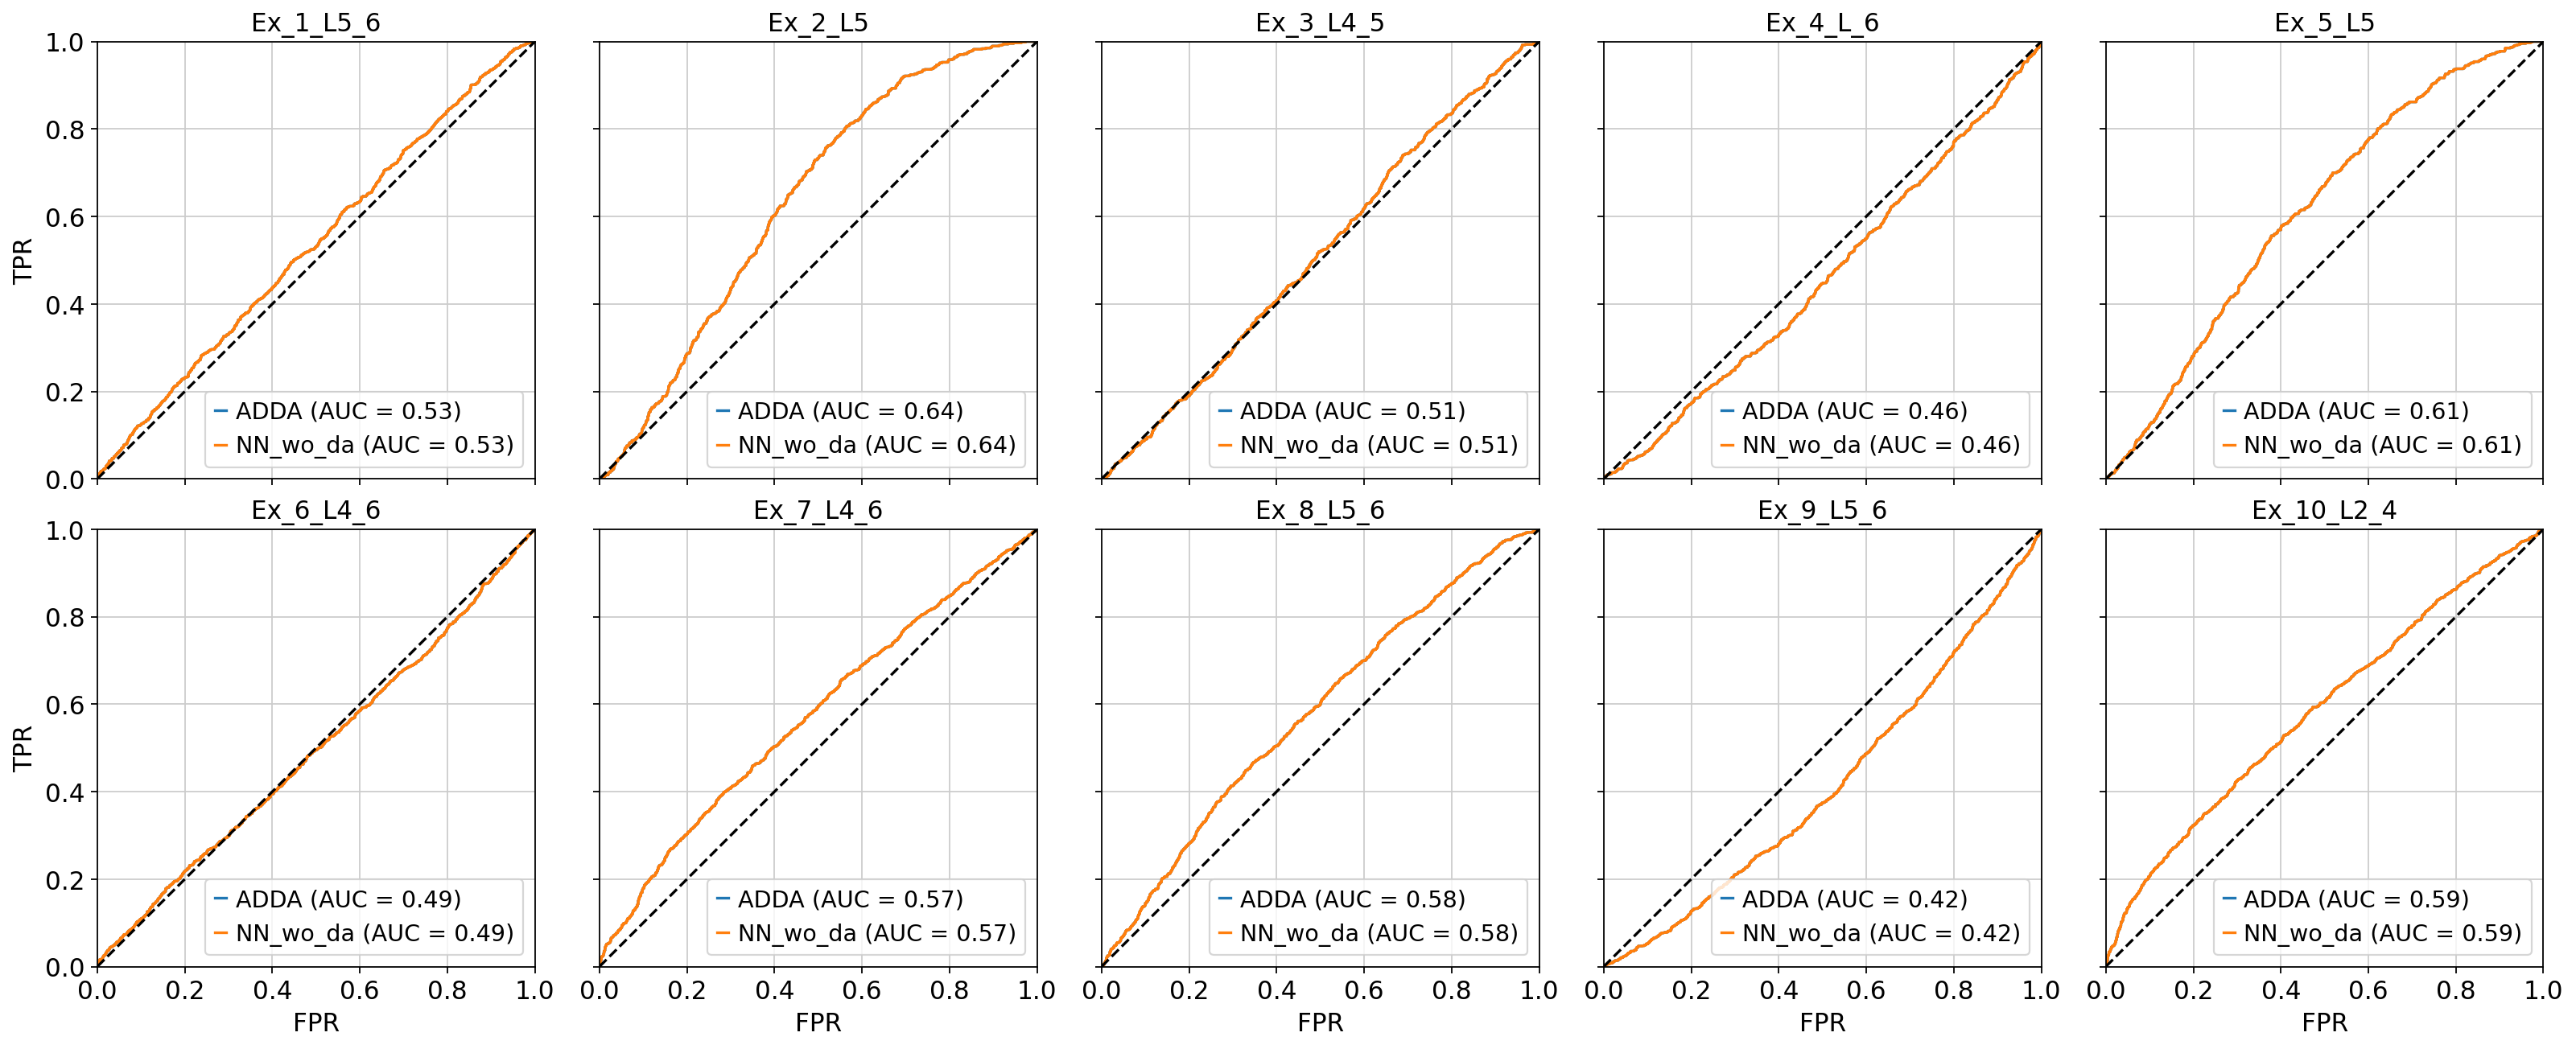

In [39]:
fig, ax = plt.subplots(2, 5, figsize=(20, 8), constrained_layout=True)

for i, num in enumerate(numlist):
    plot_cellfraction(num, adata_spatialLIBD_151673, pred_sp, ax.flat[i])
    ax.flat[i].axis("equal")
    ax.flat[i].set_xlabel("")
    ax.flat[i].set_ylabel("")

fig.show()
# plt.close()

fig, ax = plt.subplots(
    2, 5, figsize=(20, 8), constrained_layout=True, sharex=True, sharey=True
)

for i, num in enumerate(numlist):
    plot_roc(num, adata_spatialLIBD_151673, pred_sp, "ADDA", ax.flat[i])
    plot_roc(
        num,
        adata_spatialLIBD_151673,
        pred_sp_noda,
        "NN_wo_da",
        ax.flat[i],
    )
    ax.flat[i].plot([0, 1], [0, 1], transform=ax.flat[i].transAxes, ls="--", color="k")
    ax.flat[i].set_aspect("equal")
    ax.flat[i].set_xlim([0, 1])
    ax.flat[i].set_ylim([0, 1])

    ax.flat[i].set_title(f"{sc_sub_dict[num]}")

    if i >= len(numlist) - 5:
        ax.flat[i].set_xlabel("FPR")
    else:
        ax.flat[i].set_xlabel("")
    if i % 5 == 0:
        ax.flat[i].set_ylabel("TPR")
    else:
        ax.flat[i].set_ylabel("")

fig.show()
# plt.close()


/projects/wma/.conda2/envs/agreda2/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/projects/wma/.conda2/envs/agreda2/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/projects/wma/.conda2/envs/agreda2/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an erro

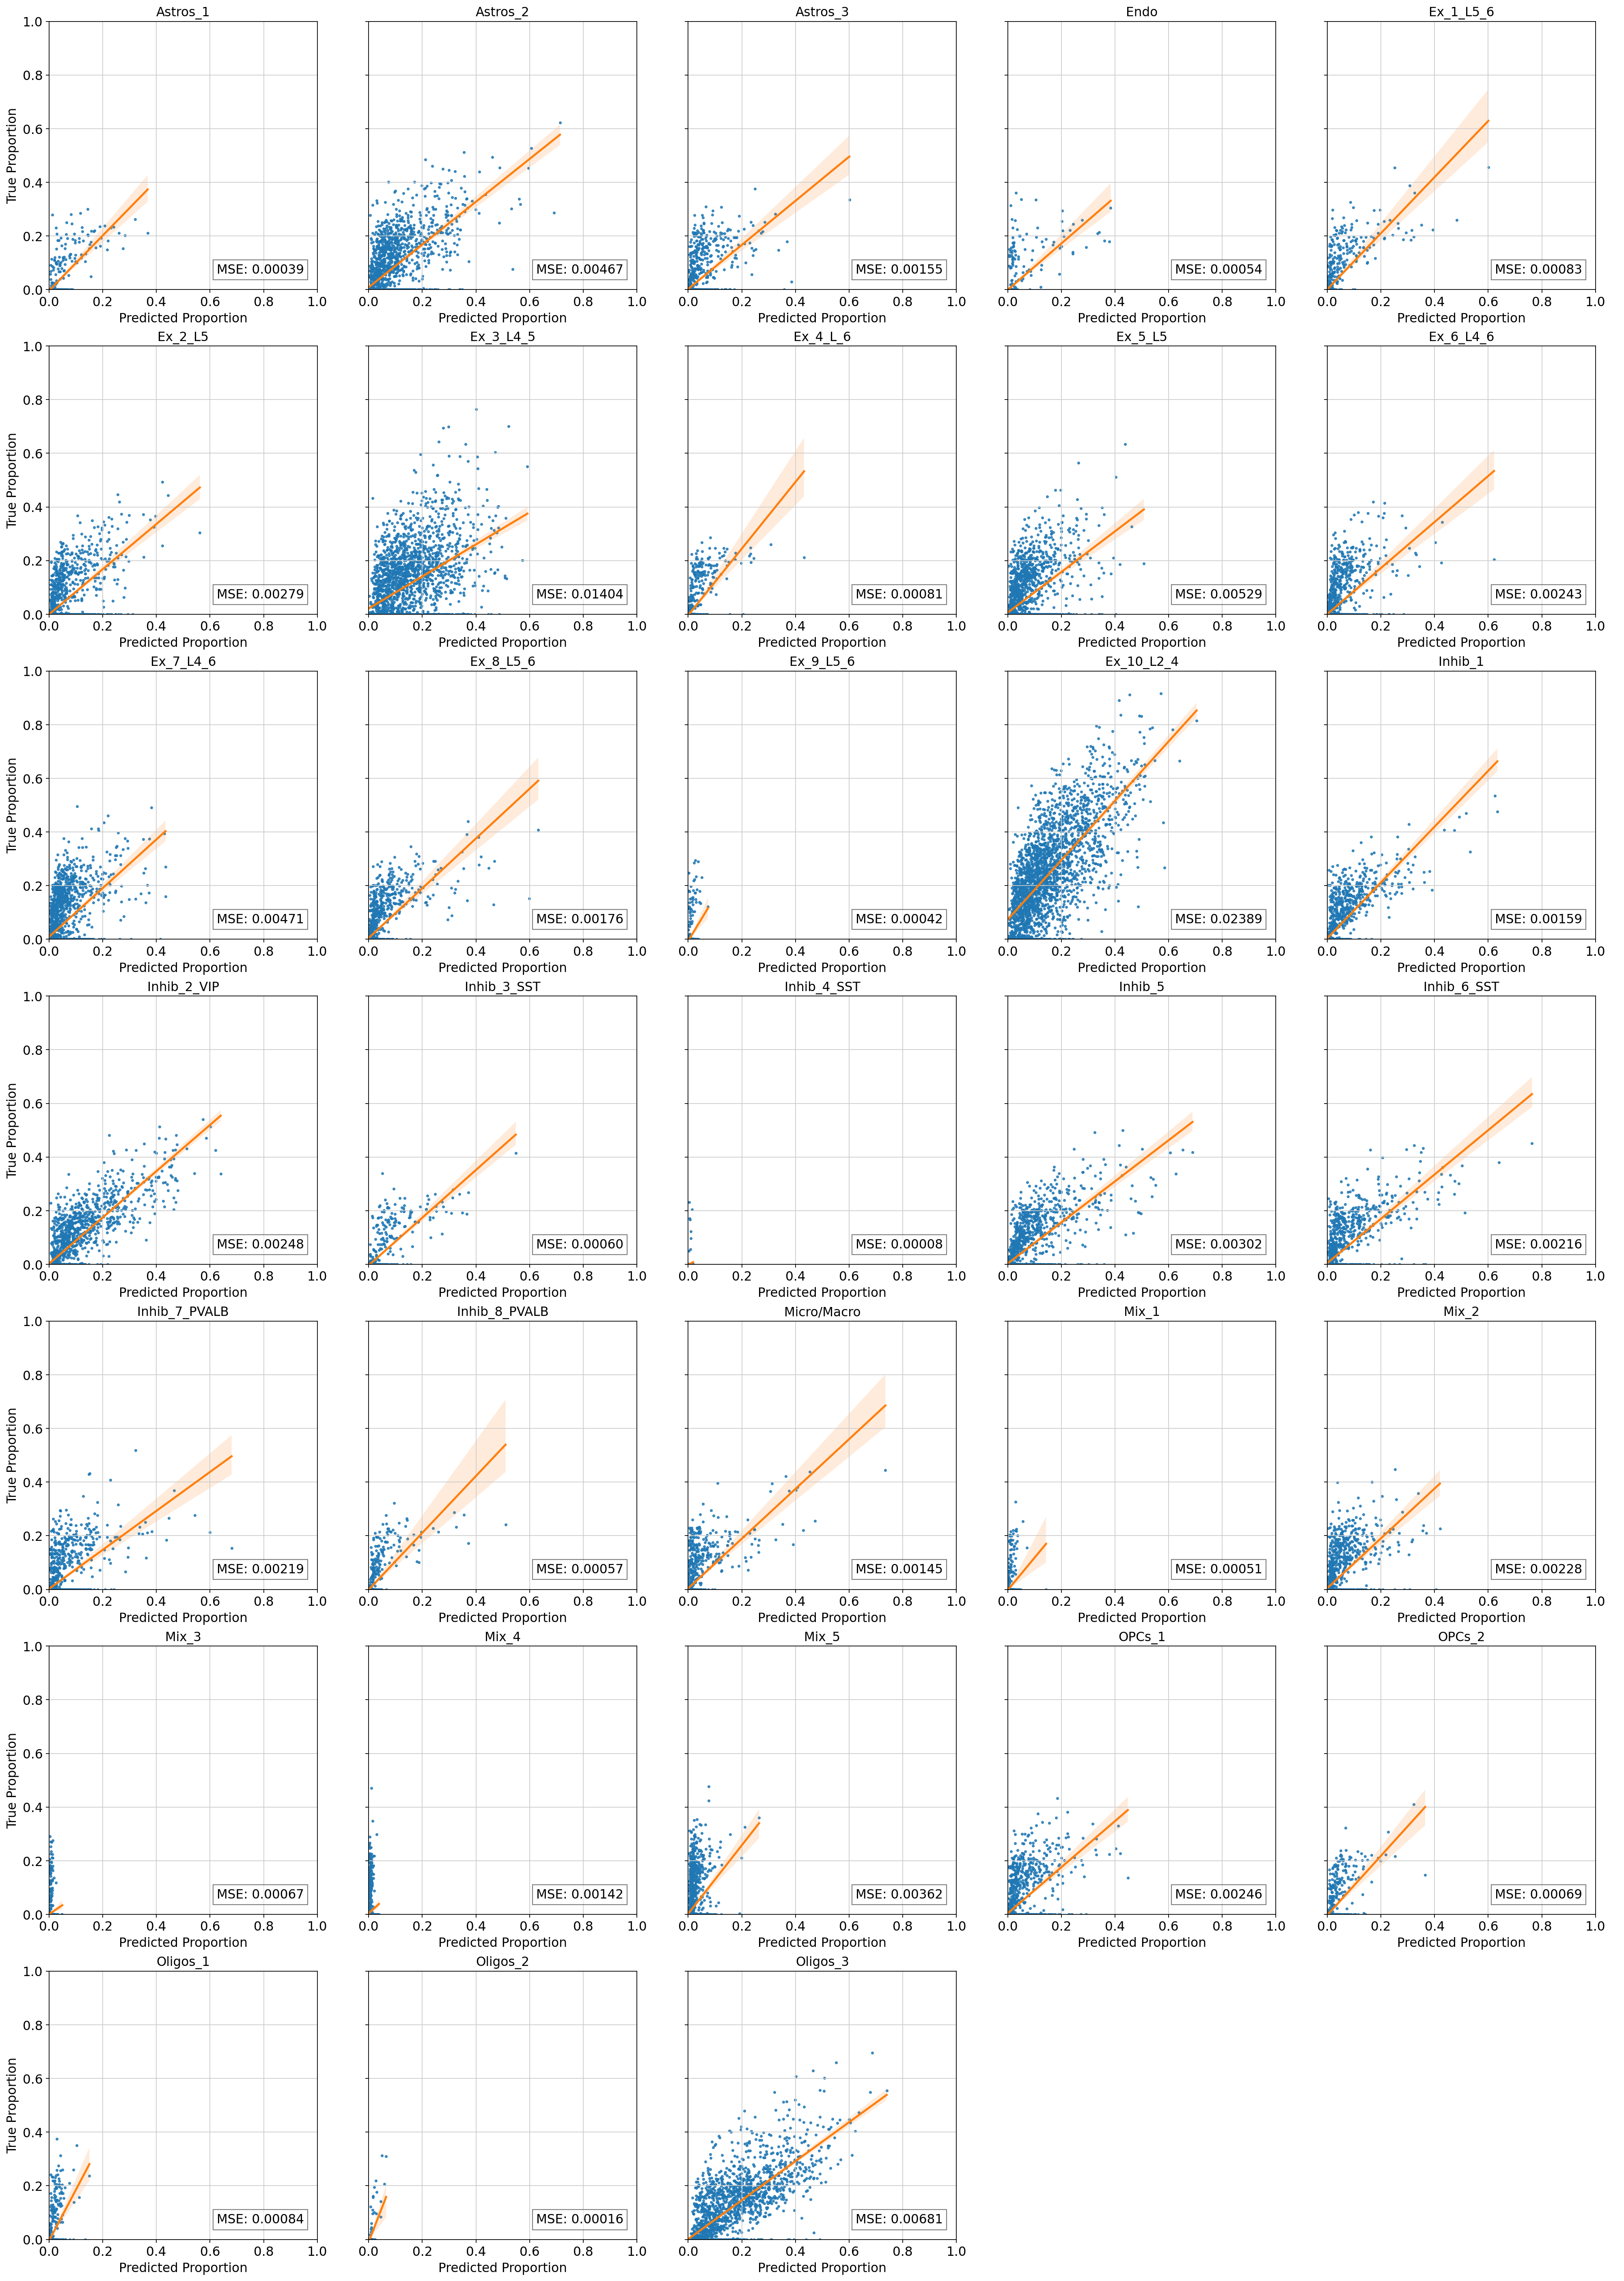

In [40]:
best_checkpoint = torch.load(os.path.join(advtrain_folder, f"best_model.pth"))
model = best_checkpoint["model"]
model.to(device)
model.eval()
model.target_inference()
model.set_encoder("source")

pred_mix = (
    F.softmax(model(torch.Tensor(sc_mix_test_s).to(device)), dim=1)
    .detach()
    .cpu()
    .numpy()
)

cell_type_nums = sc_sub_dict.keys()
nrows = ceil(len(cell_type_nums) / 5)

line_kws = {"color": "tab:orange"}
scatter_kws = {"s": 5}

props = dict(facecolor="w", alpha=0.5)

fig, ax = plt.subplots(
    nrows,
    5,
    figsize=(25, 5 * nrows),
    constrained_layout=True,
    sharex=False,
    sharey=True,
)
for i, visnum in enumerate(cell_type_nums):
    sns.regplot(
        pred_mix[:, visnum],
        lab_mix_test[:, visnum],
        line_kws=line_kws,
        scatter_kws=scatter_kws,
        ax=ax.flat[i],
    ).set_title(sc_sub_dict[visnum])
    ax.flat[i].set_aspect("equal")

    # if i >= len(cell_type_nums) - 5:
    ax.flat[i].set_xlabel("Predicted Proportion")
    # else:
    #     ax.flat[i].set_xlabel('')
    if i % 5 == 0:
        ax.flat[i].set_ylabel("True Proportion")
    else:
        ax.flat[i].set_ylabel("")
    ax.flat[i].set_xlim([0, 1])
    ax.flat[i].set_ylim([0, 1])

    textstr = (
        f"MSE: {mean_squared_error(pred_mix[:,visnum], lab_mix_test[:,visnum]):.5f}"
    )

    # place a text box in upper left in axes coords
    ax.flat[i].text(
        0.95,
        0.05,
        textstr,
        transform=ax.flat[i].transAxes,
        verticalalignment="bottom",
        horizontalalignment="right",
        bbox=props,
    )

for i in range(len(cell_type_nums), nrows * 5):
    ax.flat[i].axis("off")

plt.show()
